# MIT License
Copyright (c) 2022 Karan Raman Agrawal, Sanika Patne

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.



# Dataset Description
For this project we will be using the “UrbanSound8k” dataset, which is publicly available for academic use.

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. The audio files are in ".wav" format. 

The samples are around 4 seconds in length. 

Each sound sample is labeled with the class to which it belongs. After downloading the dataset, we see that it consists of two parts:

- Audio files in the ‘audio’ folder: It has 10 sub-folders named ‘fold1’ through ‘fold10’. Each sub-folder contains a number of ‘.wav’ audio samples eg. ‘fold1/103074–7–1–0.wav’

- Metadata in the ‘metadata’ folder: It has a file ‘UrbanSound8K.csv’ that contains information about each audio sample in the dataset such as its filename, its class label, the ‘fold’ sub-folder location, and so on. The class label is a numeric Class ID from 0–9 for each of the 10 classes. eg. The number 0 means air conditioner, 1 is a car horn, and so on. 


In [10]:
# Importing all required libararies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.test.gpu_device_name()

'/device:GPU:0'

In [11]:
# Setting Image Size and Batch Size
image_size = (512, 512)
batch_size = 16

In [12]:
# Initializing Train Data Generator
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/DSMT/Spectrogram_Dataset/Training_Data",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 7923 files belonging to 10 classes.


In [13]:
# Initializing Validation Data Generator
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/DSMT/Spectrogram_Dataset/Validation_Data",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 990 files belonging to 10 classes.


In [15]:
# Pre-Fetch Train and Valid for performance enhancement
train_ds = train_ds.prefetch(buffer_size=32)
valid_ds = valid_ds.prefetch(buffer_size=32)

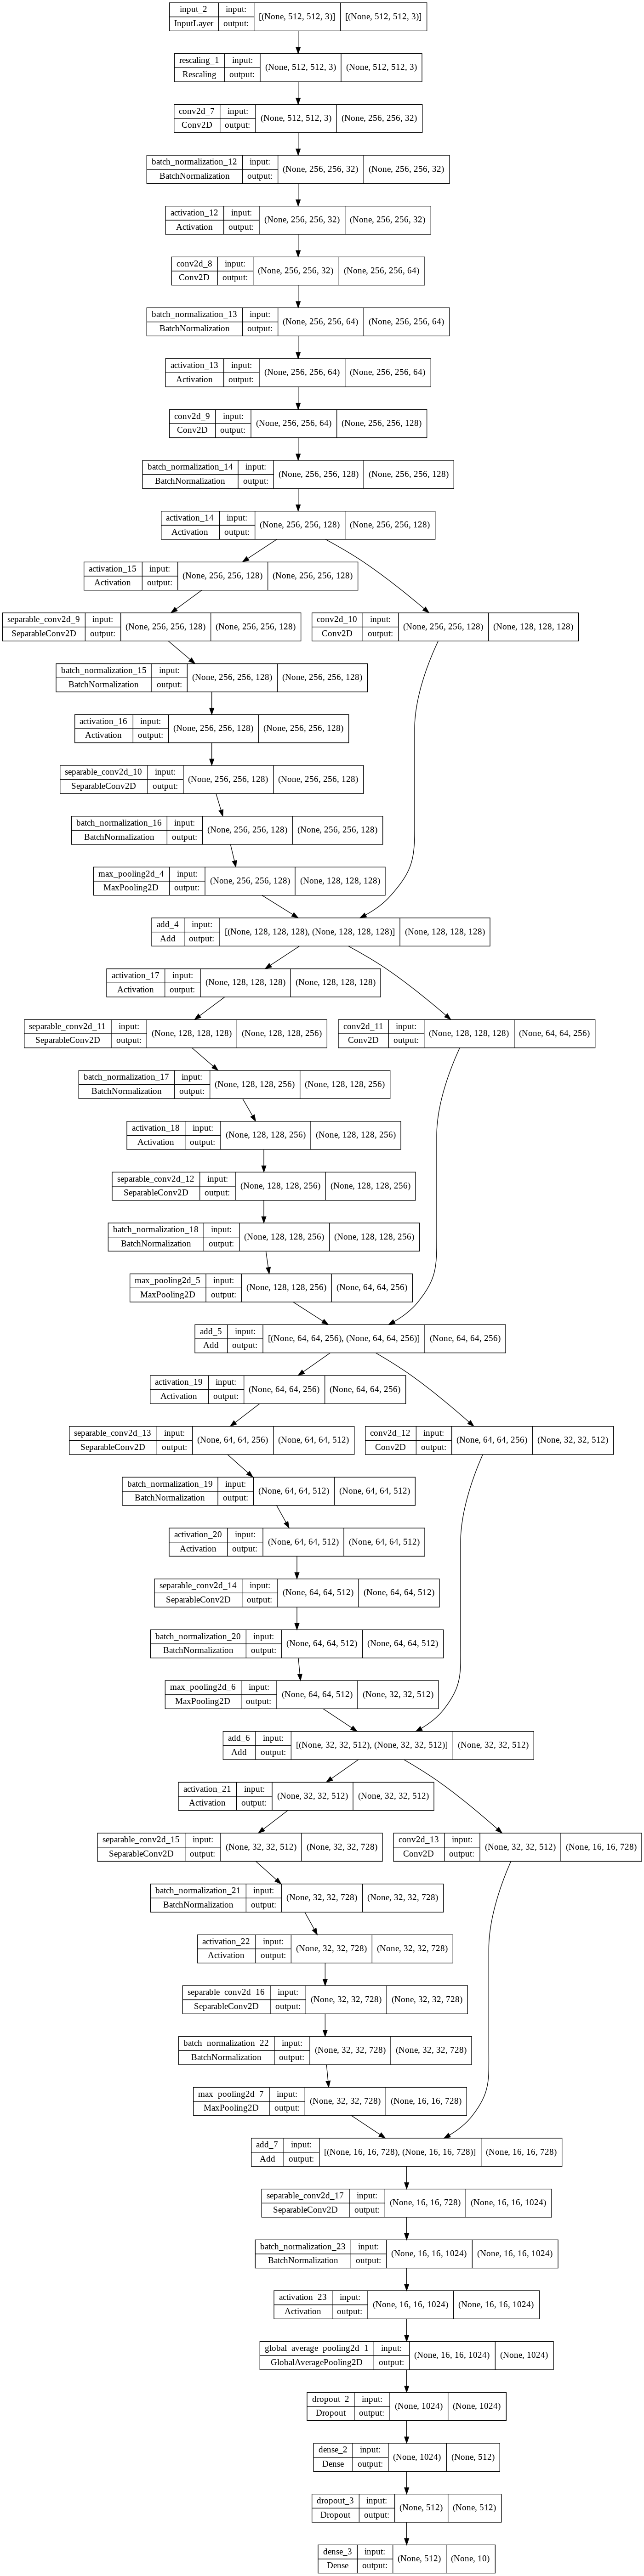

In [16]:
# Designing Model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=10)
keras.utils.plot_model(model, show_shapes=True)

In [17]:
# Training CNN on Mel-Spectrogram
epochs = 10

filepath = "/content/drive/MyDrive/DSMT/save_at_{epoch}.h5"

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=1
)

Epoch 1/10
496/496 [==============================] - ETA: 0s - loss: 1.3385 - accuracy: 0.5200
Epoch 1: val_loss improved from inf to 2.83951, saving model to /content/drive/MyDrive/DSMT/save_at_1.h5
496/496 [==============================] - 1813s 4s/step - loss: 1.3385 - accuracy: 0.5200 - val_loss: 2.8395 - val_accuracy: 0.2364
Epoch 2/10
496/496 [==============================] - ETA: 0s - loss: 0.7343 - accuracy: 0.7429
Epoch 2: val_loss did not improve from 2.83951
496/496 [==============================] - 1269s 3s/step - loss: 0.7343 - accuracy: 0.7429 - val_loss: 2.9782 - val_accuracy: 0.4768
Epoch 3/10
496/496 [==============================] - ETA: 0s - loss: 0.4875 - accuracy: 0.8353
Epoch 3: val_loss improved from 2.83951 to 1.95018, saving model to /content/drive/MyDrive/DSMT/save_at_3.h5
496/496 [==============================] - 1268s 3s/step - loss: 0.4875 - accuracy: 0.8353 - val_loss: 1.9502 - val_accuracy: 0.6202
Epoch 4/10
496/496 [==============================] 

In [19]:
import matplotlib.pyplot as plt

# Function for Plotting
def plot_performance(data):
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    # summarize history for accuracy
    ax[0].plot(data.history["accuracy"])
    ax[0].plot(data.history["val_accuracy"])
    ax[0].set_title("model accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(["train", "test"], loc="upper left")

    # summarize history for loss
    ax[1].plot(data.history["loss"], label=["loss"])
    ax[1].plot(data.history["val_loss"], label=["val_loss"])
    ax[1].set_title("model loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend(["train", "test"], loc="upper left")
    plt.show()

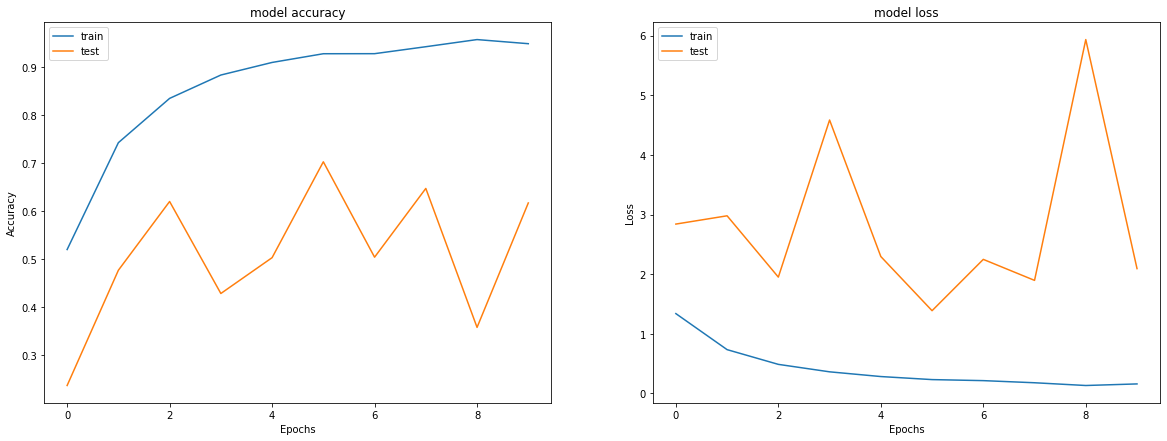

In [20]:
plot_performance(history)